Created on Friday 15 January 2021

***Group 5 - Classification
Extraction features syntaxe***

@authors : Fallou BAH

This notebook creates new features on the input dataframe, sums up the features and then finds an optimal threshold to classify gestion and non-gestion items.

In [ ]:
!python3 -m spacy download fr_core_news_md
!pip install langdetect

     |████████████████████████████████| 88.6MB 1.2MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-cp36-none-any.whl size=90338490 sha256=605479ed138c25b330ac8aacb162e4a14655dc496e10fb2a42aa8af1813ac811
  Stored in directory: /tmp/pip-ephem-wheel-cache-x93scicd/wheels/c6/18/b6/f628642acc7872a53cf81269dd1c394d96da69564ccfac5425
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')
     |████████████████████████████████| 983kB 4.2MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993194 sha256=1eb85ce5c2c01d6e55227efbe3529836b8989a882bfe15a1bc4de5b58a96bf37
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


# Create link between drive and notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os 
os.chdir('/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/')

Mounted at /content/drive


# Import

In [ ]:
import pandas as pd 
import numpy as np
import re
from tqdm import tqdm 
from string import punctuation
import spacy
import fr_core_news_md
import warnings
from textblob import TextBlob
from langdetect import detect
import matplotlib.pyplot as plt


import nltk
from nltk.stem import  WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
warnings.filterwarnings('ignore')
scaler = StandardScaler()
nlp = fr_core_news_md.load()
stop_words_french = stopwords.words('french') 
stop_words_english = stopwords.words('english') 
lemmer=WordNetLemmatizer()


# Data import

In [ ]:
data : pd.DataFrame = pd.read_json("Data.json")[['art_id','art_content','art_title']]
data = data [data['art_content'] !='']
data.head()

,art_id,art_content,art_title
1,1,La FNCDG et l’ANDCDG ont publié en septembre l...,9ème édition du Panorama de l’emploi territorial
2,2,Malgré la levée des mesures de confinement le ...,ACTUALITÉS FNCDG / COVID19
25,25,Quels étaient les objectifs poursuivis par le ...,"Interview de M. Olivier DUSSOPT, Secretaire d’..."
27,27,"La journée thématique, qui aura lieu durant le...",Journée Thématique FNCDG « Les services de san...
28,28,La 1ère journée thématique en région sur le th...,Journée Thématique FNCDG « Vers de nouveaux mo...


# Pre-processing

In [ ]:
# this function allows you to lemmatize English words

def lemmatization(word : str) -> str:
  """
  parameters
    word : word to lemmatize
  Output
    word : lemmatized word
  """
  for pos in ['a', 's', 'r', 'n', 'v']:
    word=lemmer.lemmatize(word, pos)
  return word

In [ ]:
%%time
# This function allows you to clean up keywords
def clean_lexique(link_lexique : str) -> list:
  """ Documentation
    Parameter :
      link_lexique : link of keyword
    Output : 
      list_lexique_net : list of cleaned keyword 
  """
  df_lexique: pd.DataFrame = pd.read_csv(link_lexique, sep="  ", header=None)
  df_lexique.columns: list = ['lexique']
  list_lexique = df_lexique.lexique.values.tolist()
  list_lexique_net : list = []

  for k in list_lexique :
    k=k.lower()
    k=k.replace(" d'",'')
    k=k.replace("."," ")
    k=k.replace("-"," ")
    k=k.replace("l'","")
    k=k.replace("/"," ")
    stop_word =[ 'le', 'par', 'les', 'du', 'la', 'de', "des", 'et','un','une']

    k_ :list = []
    try :
      if detect(k)=='fr':
        k_npl=nlp(k)
        for j in k_npl:
          if j.lemma_ not in stop_word:
            k_.append(j.lemma_)
      elif detect(k)=='en' :
        for j in k.split():
          j = lemmatization(j)
          if j not in stop_word:
            k_.append(j)
      else :
        k_= k.split()
    except :
      k_ = k.split()

    list_lexique_net.append(' '.join(k_))

  list_lexique_net = pd.unique(list_lexique_net).tolist()
  return list_lexique_net

link_lexique = "/content/drive/MyDrive/G5 Inter-Promo 2021/Ressources/Lexique_Gammes_Gestion.txt"
list_lexique = clean_lexique(link_lexique)
list_lexique[:5]

CPU times: user 4.26 s, sys: 133 ms, total: 4.4 s
Wall time: 4.75 s


In [ ]:
# A function that cleans the contents

def clean(content:str)->str:
  """ Documentation : 
  Parameter
      content : content
  Output
      content : cleaned content

  """
  lang = 'en'
  try :
    if detect(content) == 'fr':
      lang = 'fr'
  except :
    pass

  content=re.sub('\W+',' ',content)
  content=content.lower()

  # removes special characters
  for p in punctuation:
    content=content.replace(p," ")

  content_lemma=[]
  if lang == 'fr' :
    content_=nlp(content)
    for token in content_:
      if str(token) not in stop_words_french:
        content_lemma.append(token.lemma_)
  else :
    for token in content.split():
      if token not in stop_words_english :
        content_lemma.append(lemmatization(token))

  return ' '.join(content_lemma)

In [ ]:
# Counts the number of words
def count_words(text: str) -> int:
    """Documentation
      Parameters:
        text: text of the article
      Output:
        nb_word: number of word in  the text
    """
    # counts the number of words present in the text
    return len(text.split())

In [ ]:
# Count the number of time where the words in the list appear

def count_lexique(text : str) -> int:
    """ Documentation
    Parameters:
        text: text of the article

    Output:
        t : number of keyword in the text
    """
    t : int = 0
    m  : int = max([len(w.split()) for w in list_lexique])

    text = text.lower()
    text = text.split()
    n = len(text)
    for j in range(len(text)):
      word : str = ''
      for k in range(m):
        if j+k < n :
          word+=' '+text[j+k]
          if (word[1:] in list_lexique):   #list_lexique: List of word that we will check in the sentences
            t += 1
    return t

In [ ]:
# Count the number of sentence
def count_sentence( text : str) -> int:
    """Documentation
    Parameters:
        text: text of the article

    Output:
        n:  The number of sentence in a article
    """

    n : int = 0
   
    if not isinstance(text, str):
        text: str = str(text)

    if (text != None):
        text = text.replace("..", ".")
        text = text.replace("...", ".")
        text = text.replace("!", ".")
        text = text.replace("!!", ".")
        text = text.replace("!!!", ".")
        text = text.replace("?", ".")
        text = text.replace("??", ".")
        text = text.replace("???", ".")
        text = text.replace("?!", ".")
        text = text.replace("!?", ".")
        n = len(sent_tokenize(text))

    return n

In [ ]:
# This function allows you to create features
def create_features(data : pd.DataFrame) -> pd.DataFrame:
  ''' Documentation
    Parameters :
      data : Dataframe
    Output :
      data : Dataframe
  '''

  data ['clean_content'] = data['art_content'].apply(clean)
  data ['clean_title'] = data['art_title'].apply(clean)

  data["count_keywords_content"] : np.DataFrame = data['clean_content'].apply(count_lexique)
  data["count_keywords_title"] : np.DataFrame = data['clean_title'].apply( count_lexique)
  data["count_words_content"]: np.DataFrame = data['clean_content'].apply(count_words)
  data["count_words_title"]: np.DataFrame = data['clean_title'].apply(count_words)
  data["count_sentences"]: np.DataFrame = data['art_content'].apply(count_sentence)

  data['ratio_keywords_content']: np.DataFrame  = data['count_keywords_content'] / data['count_words_content']
  data['ratio_keywords_content']: np.DataFrame  = data['ratio_keywords_content'].fillna(0)

  data['ratio_keywords_sentence']: np.DataFrame  = data['count_keywords_content'] / data['count_sentences']
  data['ratio_keywords_sentence']: np.DataFrame  = data['ratio_keywords_sentence'].fillna(0)

  data['ratio_keywords_title']: np.DataFrame  = data['count_keywords_title'] / data['count_words_title']
  data['ratio_keywords_title']: np.DataFrame  = data['ratio_keywords_title'].fillna(0)
  
  return data

In [ ]:
%%time 
data_feat = create_features(data)

CPU times: user 36min 6s, sys: 27 s, total: 36min 33s
Wall time: 36min 38s


In [ ]:
#If you execute the codes, I advise you to save this "data_feat" dataframe 
# that you can reuse in my notebooks with the mention "gestion". 
#You can see that the execution time is about 35 minutes.

# Description



In [ ]:
data = data_feat [['count_keywords_content', 'ratio_keywords_content', 'count_keywords_title', 'ratio_keywords_title','ratio_keywords_sentence']]
data.index = data_feat.art_id
data.head()

,count_keywords_content,ratio_keywords_content,count_keywords_title,ratio_keywords_title,ratio_keywords_sentence
art_id,,,,,
1,1,0.038462,1,0.2,0.333333
2,5,0.055556,0,0.0,1.250000
25,28,0.036506,0,0.0,0.518519
27,4,0.051948,0,0.0,1.333333
28,5,0.043478,0,0.0,1.000000


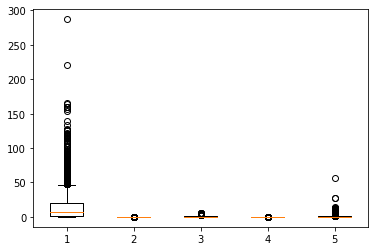

In [ ]:
plt.boxplot(data.values)
plt.show()

In [ ]:
data.describe()

,count_keywords_content,ratio_keywords_content,count_keywords_title,ratio_keywords_title,ratio_keywords_sentence
count,11608.000000,11608.000000,11608.000000,11608.000000,11608.000000
mean,14.146537,0.026187,0.356564,0.045877,0.538945
std,18.925003,0.025906,0.612974,0.083294,0.954116
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.008547,0.000000,0.000000,0.136364
50%,7.000000,0.019391,0.000000,0.000000,0.333333
75%,20.000000,0.036774,1.000000,0.076923,0.680000
max,287.000000,0.500000,6.000000,0.600000,56.000000


In [ ]:
# Centre and reduce
data_scale = scaler.fit_transform(data)

In [ ]:
# The sum of the quantities of variance explained for the first 3 principals components

pca = PCA(n_components=3)
Xp = pca.fit_transform(data_scale)

pca.explained_variance_ratio_.sum()

0.8820367892768468

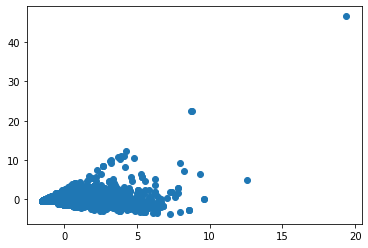

In [ ]:
# Display on the first 2 axes
plt.scatter(Xp[:,0],Xp[:,1])
plt.show()

# Thresholding

In [ ]:
# This function projects the data dataframe onto the keywords, 
# then normalises and calculates the sum of the keywords for each item. 

def sum_keyword(data: pd.DataFrame = data)-> pd.DataFrame:
  """
  Parameters :
    data : default the bow dataframe 
  Output :
    data : dataframe
  """
  data_scale = scaler.fit_transform(data)
  data = pd.DataFrame(data_scale, index=data.index, columns=data.columns)
  data['sum_keyword'] = np.sum(data.T).tolist()


  # extend the interval between 0 and 1
  m = min(data['sum_keyword'].values)
  n = max(data['sum_keyword'].values)
  data['sum_keyword'] = (data['sum_keyword']-m)/(n-m)
  return data

In [ ]:
data = sum_keyword()
data.head()

,count_keywords_content,ratio_keywords_content,count_keywords_title,ratio_keywords_title,ratio_keywords_sentence,sum_keyword
art_id,,,,,,
1,-0.694695,0.473828,1.049740,1.850425,-0.215509,0.092975
2,-0.483325,1.133710,-0.581721,-0.550806,0.745282,0.058411
25,0.732051,0.398333,-0.581721,-0.550806,-0.021410,0.053908
27,-0.536168,0.994450,-0.581721,-0.550806,0.832627,0.056766
28,-0.483325,0.667489,-0.581721,-0.550806,0.483248,0.046973


In [ ]:
# Distribution of the sum of keywords
data.sum_keyword.describe()

count    11608.000000
mean         0.054278
std          0.057036
min          0.000000
25%          0.012314
50%          0.032714
75%          0.086297
max          1.000000
Name: sum_keyword, dtype: float64

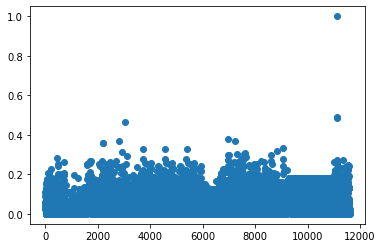

In [ ]:
# Visualization
plt.scatter(range(len(data)),data.sum_keyword.values.tolist())

In [ ]:
# This function with a threshold separates the dataframe in 2. 
# Its explanatory variables and its variable to be explained

def threshold_breakdown(threshold : int, data : pd.DataFrame) -> tuple :
  """
  Parameter :
    threshold : threshold
    data : dataframe
  Output :
    X, y 
  """
  # Thresholding
  index_no = data[data['sum_keyword']<=threshold].index.tolist()
  index_ = data[data['sum_keyword']>threshold].index.tolist()

  # Labelling
  data.loc[index_no, 'label'] = 0
  data.loc[index_, 'label'] = 1

  # Breakdown
  X = data.drop(['label','sum_keyword'], axis=1)
  y = data.label.values
  return X, y

100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


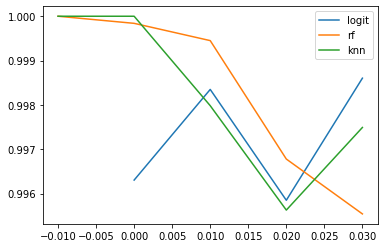

CPU times: user 3.36 s, sys: 284 ms, total: 3.64 s
Wall time: 3.37 s


In [ ]:
# Searching for the optimal threshold to differentiate
#  between gestion and non-gestion products per model. 
%%time
data : pd.DataFrame = sum_keyword()
m :int = int(min(data.sum_keyword.tolist()))-1

scores :list = []
ss :list = []

models = {
    'logit' : LogisticRegression(),
    'rf' : RandomForestClassifier(),
    'knn': KNeighborsClassifier()
}

for j in tqdm(models.keys()):
  score : list = []
  s : list = []
  for i in np.arange(m, 4,1)/100:

    X, y = threshold_breakdown(i,  data)
    X_train, X_val, Y_train, Y_val = train_test_split (X, y, test_size = 0.30, random_state = 40) 
    try :
      model = models[j]
      model.fit(X_train, Y_train)
      y_pred = model.predict(X_val)
      score.append(f1_score(Y_val, y_pred))
      s.append(i)
    except :
      pass
  scores.append(score)
  ss.append(s)
  plt.plot(s, score, label=j)
  plt.legend()
plt.show()

In [ ]:
threshold = 0
data = sum_keyword()
X, y = threshold_breakdown(threshold,  data)

In [ ]:
# this function allows you to train a model either by cross validation 
# and display its accuracy and f1_score or by simple training 
# and display its accuracy and f1_score and also its confusion matrix if you wish.

def training(model, if_plot : bool = False, if_val_cross : bool = False) :
  """
  Parameters :
    model : model
    if_plot : if you want to display your confusion matrix
    if_val_cross : if you want to train by cross-validation
    Output :
  """
  if if_val_cross :
    print("accuracy ...")
    print(cross_val_score(model, X, y, cv=5))

    print("f1_score ...")
    print(cross_val_score(model, X, y, cv=5, scoring='f1'))

  else :

    X_train, X_val, Y_train, Y_val = train_test_split (X, y, test_size = 0.30, random_state = 40) 
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_val)

    print("accuracy ...")
    print(model.score(X_val, Y_val))
    print("f1_score ...")
    print(f1_score(Y_val, y_pred))

    if if_plot:
      plot_confusion_matrix(model, X_val, Y_val, cmap='Blues', normalize=None,
                      display_labels=['No gestion', 'Gestion']);

accuracy ...
1.0
f1_score ...
1.0


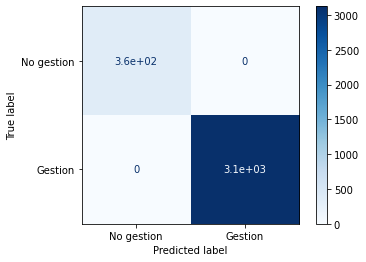

In [ ]:
# Logit 

model = KNeighborsClassifier()
training(model, True)

In [ ]:
# Logit 

training(model, False, True)

accuracy ...
[1. 1. 1. 1. 1.]
f1_score ...
[1. 1. 1. 1. 1.]


# Labeling and Output

In [ ]:
label = pd.DataFrame()
label['art_id'] = data_feat.art_id.tolist()
label['label_gestion'] = data.label.tolist()

In [ ]:
label['label_gestion'] = label['label_gestion'].astype(int)
label.head()

,art_id,label_gestion
0,1,1
1,2,1
2,25,1
3,27,1
4,28,1


In [ ]:
y=label.label_gestion
print('The number of gestion items :',len(y[y==1]))

The number of gestion items : 10377


In [ ]:
print('The number of no gestion items :',len(y[y==0]))

The number of no gestion items : 1231


In [ ]:
label.to_csv('../Output/Innovation/label_gestion.csv', index=False)